In [1]:
import json
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import os

import tensorflow as tf
import tensorflow.contrib.eager as tfe
tf.enable_eager_execution()

dataset = '/home/martin/Programación/node-python/diabetes-ml/server/diabetes.csv'


In [2]:
datos = pd.read_csv(dataset)
datos.head()

Embarazos  Glucosa  PresiónSanguínea  GrosorDeLaPiel  Insulina   IMC  \
0          6      148                72              35         0  33.6   
1          1       85                66              29         0  26.6   
2          8      183                64               0         0  23.3   
3          1       89                66              23        94  28.1   
4          0      137                40              35       168  43.1   

   FunciónDePedigríDiabetes  Edad  Resultado  
0                     0.627    50          1  
1                     0.351    31          0  
2                     0.672    32          1  
3                     0.167    21          0  
4                     2.288    33          1

In [3]:
datos.describe()

Embarazos     Glucosa  PresiónSanguínea  GrosorDeLaPiel    Insulina  \
count  768.000000  768.000000        768.000000      768.000000  768.000000   
mean     3.845052  120.894531         69.105469       20.536458   79.799479   
std      3.369578   31.972618         19.355807       15.952218  115.244002   
min      0.000000    0.000000          0.000000        0.000000    0.000000   
25%      1.000000   99.000000         62.000000        0.000000    0.000000   
50%      3.000000  117.000000         72.000000       23.000000   30.500000   
75%      6.000000  140.250000         80.000000       32.000000  127.250000   
max     17.000000  199.000000        122.000000       99.000000  846.000000   

              IMC  FunciónDePedigríDiabetes        Edad   Resultado  
count  768.000000                768.000000  768.000000  768.000000  
mean    31.992578                  0.471876   33.240885    0.348958  
std      7.884160                  0.331329   11.760232    0.476951  
min      0.000000                  0.078000   21.000000    0.000000  
25%     27.300000                  0.243750   24.000000    0.000000  
50%     32.000000                  0.372500   29.000000    0.000000  
75%     36.600000                  0.626250   41.000000    1.000000  
max     67.100000                  2.420000   81.000000    1.000000

In [4]:
datos.hist(figsize=(12,12));
datos['Resultado'].value_counts().plot(kind='bar')

In [5]:
X = datos[['Embarazos',
           'Glucosa',
           'PresiónSanguínea',
           'GrosorDeLaPiel',
           'Insulina',
           'IMC',
           'FunciónDePedigríDiabetes',
           'Edad']] 
Y = datos['Resultado']


In [6]:
#convertir el dataset en tensores
def parse_csv(line):
    muestra_default = [[0.], [0.], [0.], [0.], [0.], [0.], [0.], [0.], [0]]  # sets field types
   
    parsed_line = tf.decode_csv(line, muestra_default) #Cada columna del dataset se asigna a un tensor.

    # Los primeros 8 campos son caracteristicas que se combinan en un solo tensor
    features = tf.reshape(parsed_line[:-1], shape=(8,))
    # Last field is the label
    label = tf.reshape(parsed_line[-1], shape=())
    return features, label

In [7]:
train_dataset = tf.data.TextLineDataset(dataset)
train_dataset = train_dataset.skip(1)             # skip the first header row
train_dataset = train_dataset.map(parse_csv)      # parse each row
train_dataset = train_dataset.shuffle(buffer_size=200)  # randomize
train_dataset = train_dataset.batch(140)

# View a single example entry from a batch
#iterator = train_dataset.make_one_shot_iterator()
#features, label = iterator.get_next()

features, label = tfe.Iterator(train_dataset).next()
print("example features:", features[26])

example features: tf.Tensor([  7.    160.     54.     32.    175.     30.5     0.588  39.   ], shape=(8,), dtype=float32)


In [8]:
#Definición del modelo
#sigmoid
#relu
model = tf.keras.Sequential([
  tf.keras.layers.Dense(10, activation="relu", input_shape=(8,)), 
  tf.keras.layers.Dense(15, activation="relu"),     
  tf.keras.layers.Dense(2)
])

In [9]:
def loss(model, x, y):
    y_ = model(x)
    return tf.losses.sparse_softmax_cross_entropy(labels=y, logits=y_)

def grad(model, inputs, targets):
    with tfe.GradientTape() as tape:
        loss_value = loss(model, inputs, targets)
    return tape.gradient(loss_value, model.variables)

In [10]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)

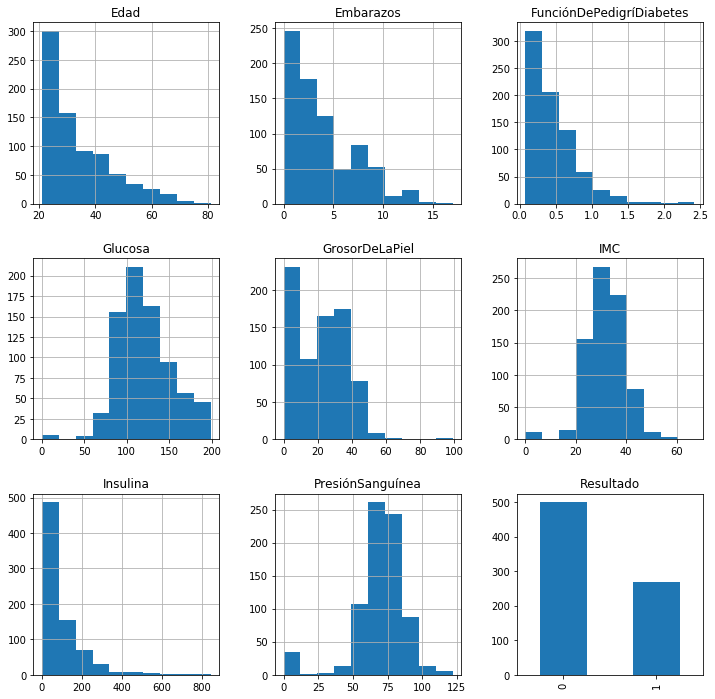

Época 000: Pérdida: 4.073, Eficiencia: 53.385%
Época 050: Pérdida: 0.595, Eficiencia: 67.839%
Época 100: Pérdida: 0.579, Eficiencia: 70.312%
Época 150: Pérdida: 0.576, Eficiencia: 70.312%
Época 200: Pérdida: 0.572, Eficiencia: 70.052%


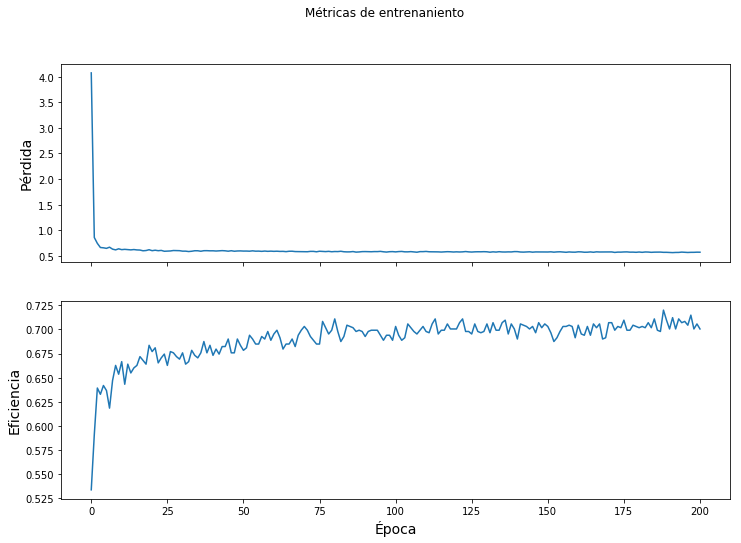

In [11]:
# Entrenamiento
plt.show()
train_loss_results = []
train_accuracy_results = []

resultados_entrenamiento = {} 
resultados_entrenamiento['resultados'] = []

num_epochs = 201

for epoch in range(num_epochs):
    epoch_loss_avg = tfe.metrics.Mean()
    epoch_accuracy = tfe.metrics.Accuracy()

      # Loop de entrenamiento usando batches
    for x, y in tfe.Iterator(train_dataset):
        # Optimizando el modelo
        grads = grad(model, x, y)
        optimizer.apply_gradients(zip(grads, model.variables),
                                  global_step=tf.train.get_or_create_global_step())

        # Track progress
        epoch_loss_avg(loss(model, x, y))  # add current batch loss
        # compare predicted label to actual label
        epoch_accuracy(tf.argmax(model(x), axis=1, output_type=tf.int32), y)

        # end epoch
    train_loss_results.append(epoch_loss_avg.result())
    train_accuracy_results.append(epoch_accuracy.result())
    
    if epoch % 50 == 0:
        resultados_entrenamiento['resultados'].append({  
            'epoca': epoch,
            'perdida':'{:.3f}'.format(epoch_loss_avg.result()),
            'eficiencia':'{:.3%}'.format(epoch_accuracy.result()),
        })        
        
        print("Época {:03d}: Pérdida: {:.3f}, Eficiencia: {:.3%}".format(epoch,
                                                                    epoch_loss_avg.result(),
                                                                    epoch_accuracy.result()))
with open('resultados_entrenamiento.json', 'w') as outfile:  
    json.dump(resultados_entrenamiento, outfile)
    
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Métricas de entrenaniento')

axes[0].set_ylabel("Pérdida", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Eficiencia", fontsize=14)
axes[1].set_xlabel("Época", fontsize=14)
axes[1].plot(train_accuracy_results)

plt.show()



In [12]:
# Generar predicciones

resultados = ["No", "Si"]
data = {} 
data['predicciones'] = []  

with open('inputs_data.json') as json_data:
    d = json.load(json_data)
    #print (d['muestras'][0]['Embarazos'])

    
#predict_dataset = tf.convert_to_tensor([
#    [6.0   , 148.0   ,  72.0   ,  35.0   ,   0.0   ,  33.6  ,   0.627,    50.0   ,],
#    [61.0   , 18.0   ,  10.0   ,  65.0   ,   0.0   ,  12.6  ,   0.927,    55.0   ,],
#    [40.   , 110.0  ,  92.0   ,   0.0  ,   0.0  ,  37.6  ,   0.191, 30.0    ]
#    
#])

predict_dataset = tf.convert_to_tensor([
    [d['muestras'][0]['Embarazos'],
     d['muestras'][0]['Glucosa'],
     d['muestras'][0]['PresiónSanguínea'],
     d['muestras'][0]['GrosorDeLaPiel'],
     d['muestras'][0]['Insulina'],
     d['muestras'][0]['IMC'],
     d['muestras'][0]['FunciónDePedigríDiabetes'],
     d['muestras'][0]['Edad'],],    
])


predicciones = model(predict_dataset)

for i, logits in enumerate(predicciones):
    index = tf.argmax(logits).numpy()
    resultado = resultados[index]
    print("Pedicción diabetes {} : {}".format(i, resultado))   
    data['predicciones'].append({  
        'resultado': resultado,
    })
    
with open('resultado.json', 'w') as outfile:  
    json.dump(data, outfile)


Pedicción diabetes 0 : Si
